# Model Monitoring Test Example

Feel free to use the script below as a playground to test the model_monitoring functionality used to generate the examples in the readme.

We have methods for change-point detection and monitoring visualisation. Each are provided in the model_monitoring.py example. Ideally this could serve as a utilities script to add in generic error-flagging / monitoring functionality for all our model monitoring needs. 

Enjoy :)

# Installation

Please create a python venv to run the following scripts. 

##### Create virtual environment

- `python3.9 -m venv venv`


##### Activate the environment

- `. ./venv/bin/activate`


##### Install requirements

- `pip install -r requirements.txt`


##### Add environment to the jupyter kernel

- `python -m ipykernel install --user --name=venv`



##### Enjoy!

## Dependencies

In [1]:
%load_ext autoreload
%autoreload 2
import model_monitoring
import pandas as pd
import numpy as np
np.random.seed(1234)

## Ingest model input features data pull (previous-1yr)

* Generate features with artificial changepoints and bad_data flags to test ruptures method.

In [2]:
## This is just a template so create some synthetic data here
n_features = 7
n_history = 365
end_date = pd.Timestamp.today().date()
start_date = end_date - pd.Timedelta(str(int(n_history-1))+'D')
dates = pd.date_range(start_date, end_date, freq='1d')
X = np.random.randn(n_history,n_features)

## inject artificial feature offsets
offsets = 5*np.random.randn(n_features)
X = X + offsets

#Add nans and infinities
X[10:12,3] = np.nan
X[40:42,3] = np.inf

## inject artifical trend
idx_trend_feature = 4
idx_trend_start = int(n_history/2)
idx_trend_end = int(3/4*n_history)
trend = 0.1*(np.arange(n_history) - idx_trend_start) + X[idx_trend_start,idx_trend_feature]
trend[:idx_trend_start]=0
trend[idx_trend_end:]=trend[idx_trend_end]
X[:, idx_trend_feature] += trend 


## simulate dead-period
idx_trend_feature = 5
idx_trend_start = int(n_history/2)
idx_trend_end = int(3/4*n_history)
X[idx_trend_start:idx_trend_end, idx_trend_feature] = 0

## volatility change
idx_trend_feature = 6
idx_trend_start = int(n_history/2)
idx_trend_end = int(3/4*n_history)
xm = X[idx_trend_start:idx_trend_end, idx_trend_feature].mean()
X[idx_trend_start:idx_trend_end, idx_trend_feature] = (X[idx_trend_start:idx_trend_end, idx_trend_feature] - xm)*10 + xm


df = pd.DataFrame(X,columns = ['feature_'+str(i) for i in range(n_features)])
df.index = dates

In [3]:
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
2021-06-17,-0.438863,-3.088310,2.798946,-1.005434,3.688932,-1.687321,0.270607
2021-06-18,-1.546821,-1.881638,-0.876445,0.457254,5.401467,-1.621160,-2.610237
2021-06-19,-1.244375,-1.895216,1.771693,-0.403690,5.730679,-4.121390,-0.791628
2021-06-20,-1.566267,-1.703913,1.919678,0.625370,3.940216,-1.898930,-2.406009
2021-06-21,-1.093406,-0.838365,0.968399,-0.355344,5.457100,-1.528546,0.274735
...,...,...,...,...,...,...,...
2022-06-12,-0.258112,-1.650203,2.909504,0.634007,18.055868,-3.257387,-1.509393
2022-06-13,0.028687,-1.615886,2.528402,-0.727883,16.618937,-2.883644,-0.841138
2022-06-14,-0.129454,-1.553269,2.641486,0.610981,19.261557,-2.108895,-1.575186
2022-06-15,-2.630056,-4.127413,0.927134,-3.090024,17.569060,-1.080489,-0.826040


## Change-point detection

* Summarize change points in ALL model inputs

In [4]:
change_points_for_chart = model_monitoring.calculate_change_points(df, percentiles= [25,50,75],explode=False).reset_index(drop=True)
change_points = model_monitoring.drop_end_changepoints(change_points_for_chart,explode=False)

In [5]:
change_points

,feature_name,datetime,percentile,value,description
0,feature_3,2021-06-27,NaN,NaN,NaN
1,feature_3,2021-06-28,NaN,NaN,NaN
2,feature_3,2021-07-27,NaN,NaN,Inf
3,feature_3,2021-07-28,NaN,NaN,Inf
4,feature_4,2021-12-19,"[25, 50, 75]","[3.7852915414512722, 4.471509624763923, 5.0657...",trend/volatility
5,feature_4,2022-02-12,"[25, 50, 75]","[9.592277409089494, 11.24070778517874, 12.4452...",trend/volatility
6,feature_5,2021-12-14,"[25, 50, 75]","[-3.216606373186134, -2.642532831705682, -1.88...",trend/volatility
7,feature_5,2022-03-19,"[25, 50, 75]","[0.0, 0.0, 0.0]",trend/volatility
8,feature_6,2021-12-19,"[25, 50, 75]","[-1.2596951694736649, -0.6105397247808182, -0....",trend/volatility
9,feature_6,2022-03-14,"[25, 50, 75]","[-8.189753715190541, -1.5381348453703132, 5.12...",trend/volatility


## Monitoring Output

* Generate a multi page pdf output of all features with any flagged change points

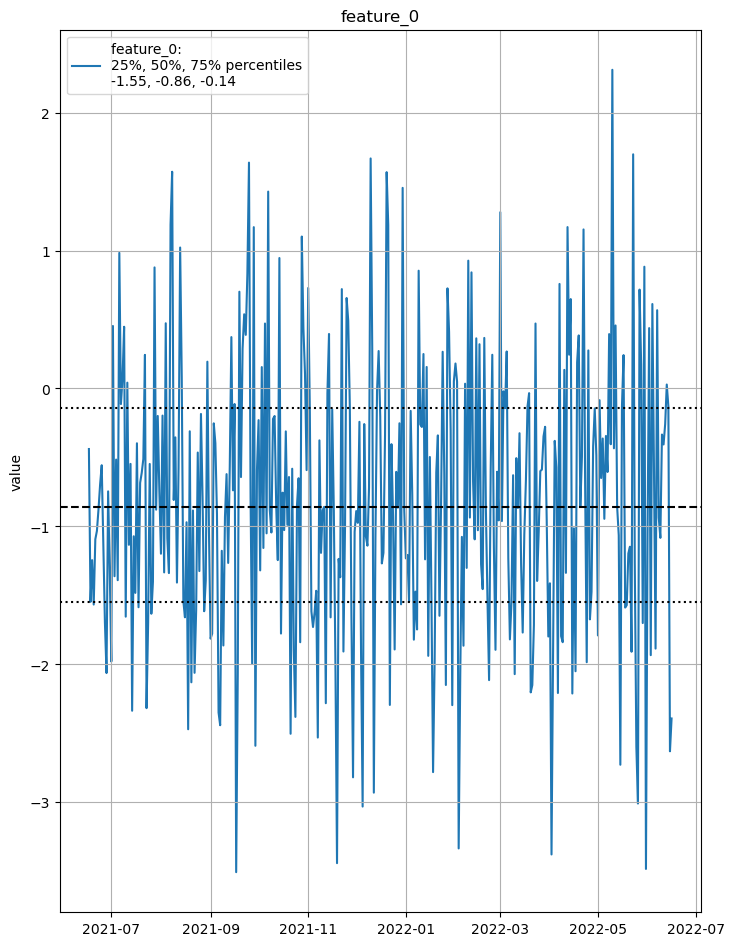

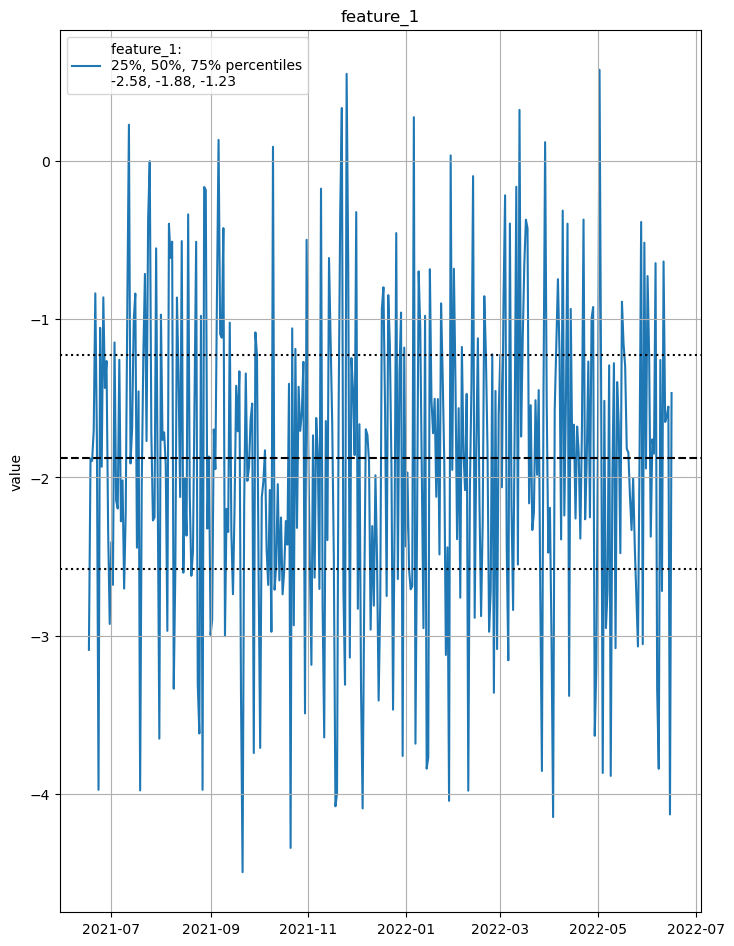

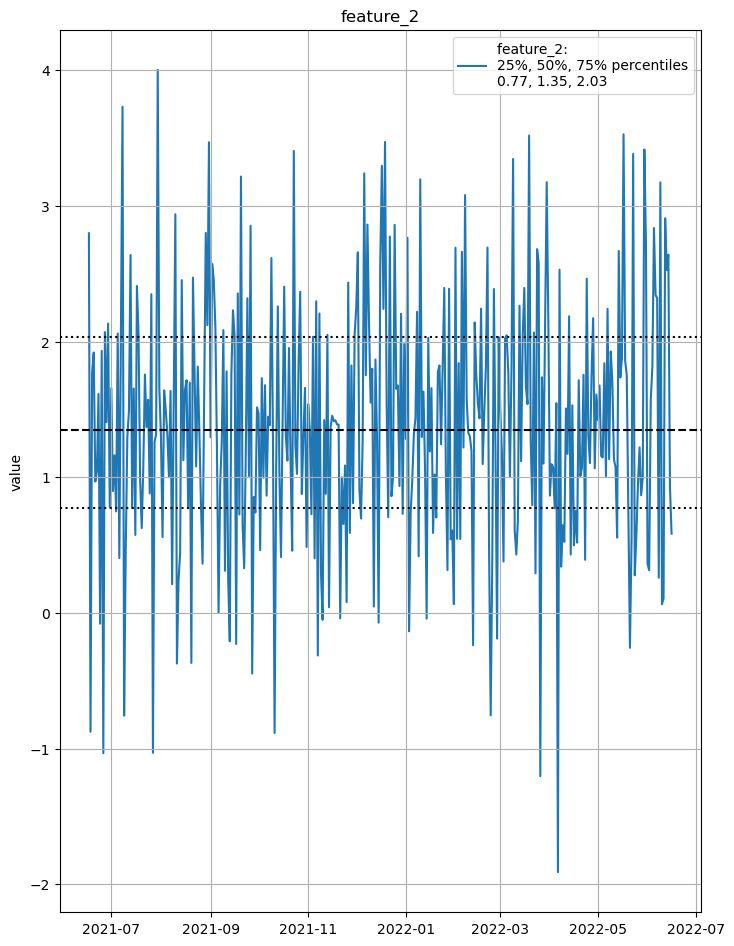

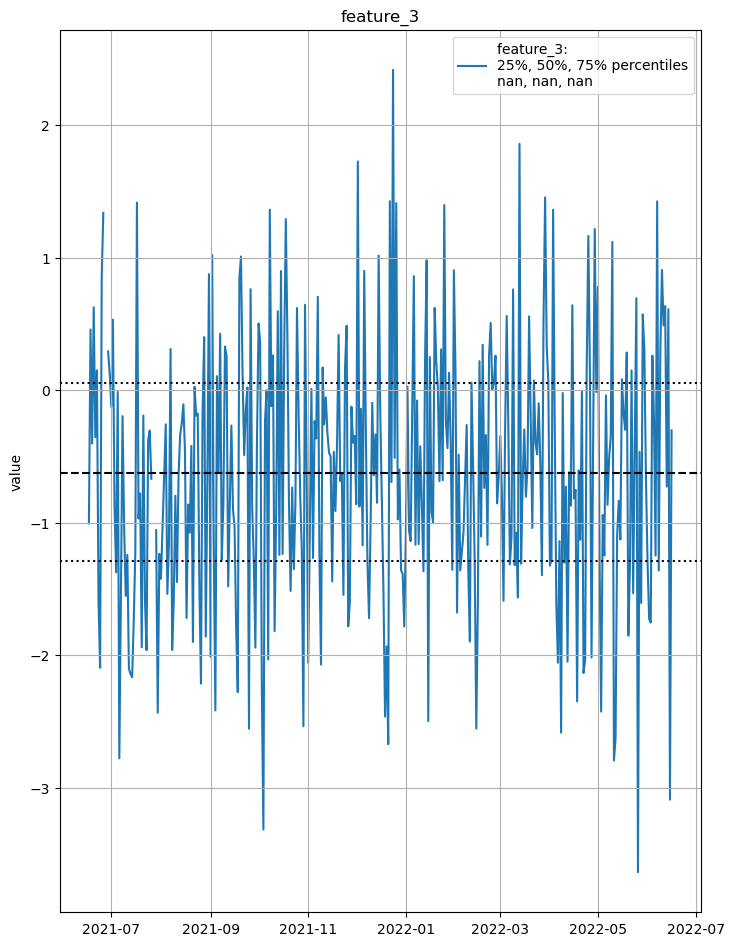

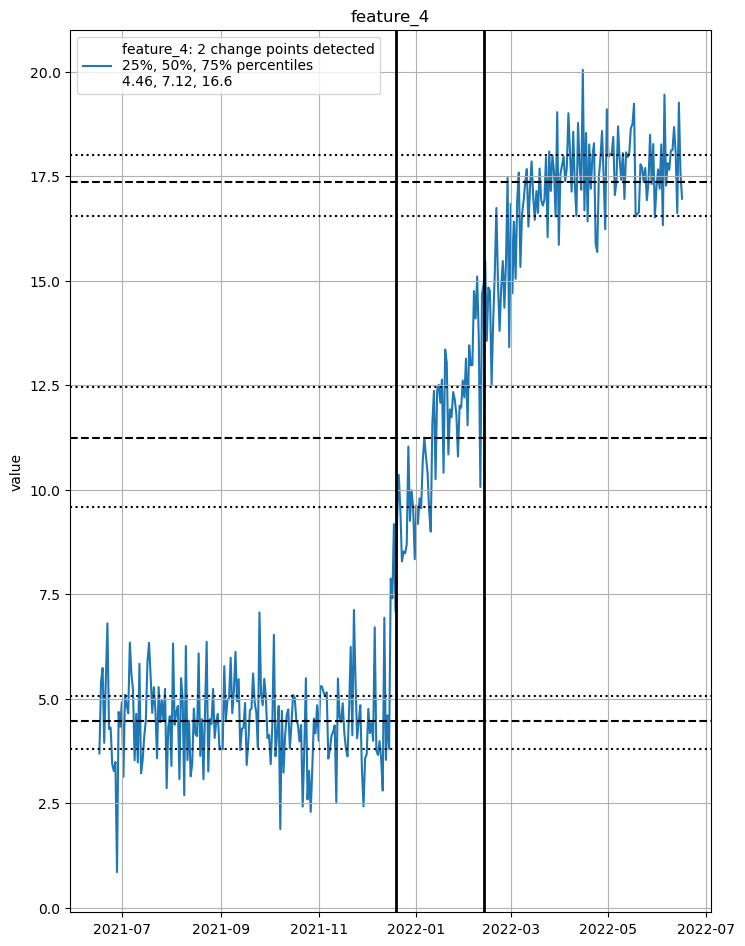

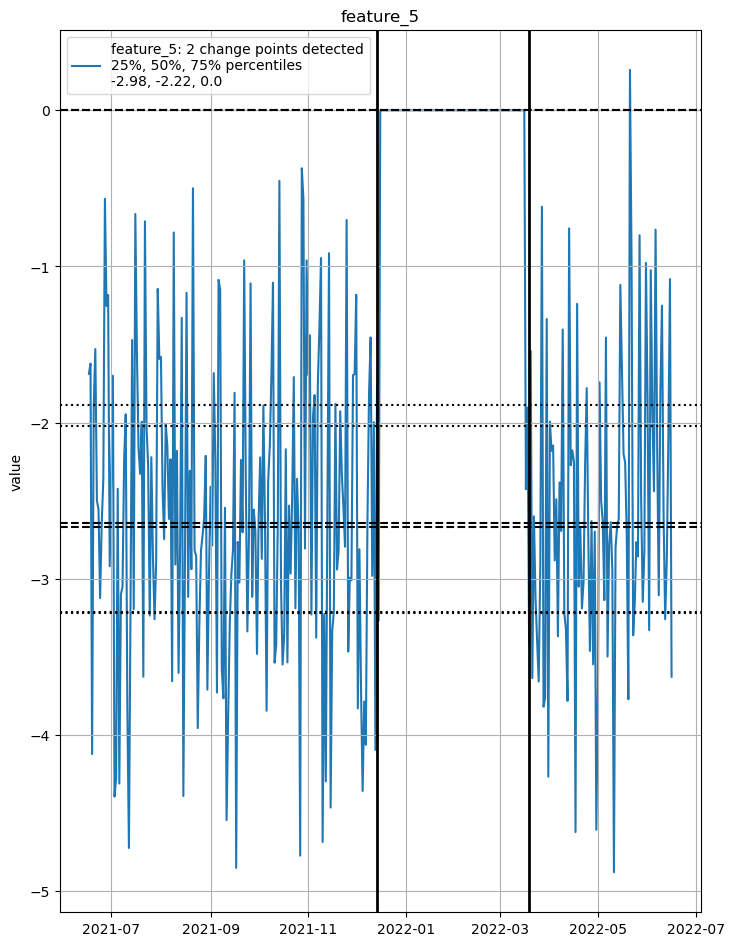

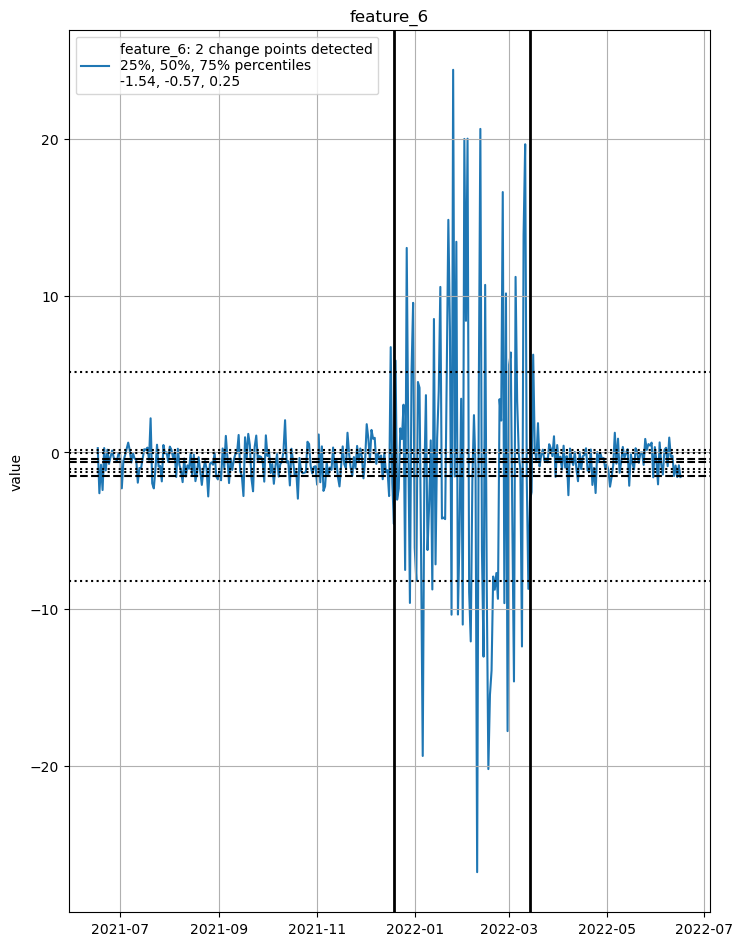

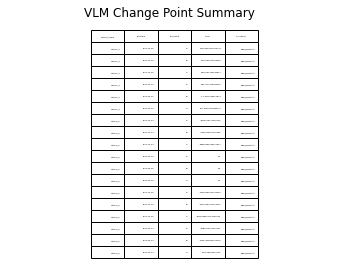

In [6]:
pdf_file = './img/variable_level_monitoring.pdf'
model_monitoring.generate_vlm_display(df, pdf_file, percentiles = [25,50,75], change_points=change_points_for_chart)    